# Support Vector Machnes (SVM) decoding and surrogates

<div class="alert alert-block alert-info">


### ABOUT THIS LESSON 
---

Lesson time: 60 m   
Contributors: Bryan Souza, Davide Spalla

***In this lesson you will learn:***
- How to train a Support Vector Machine (SVM) to decode the presence of absence of a stimulus from neural activity 
- What the bias and variance of a classifier are
- How to assess the performance of a classifier using shuffling methods to create surrogate data



## Introduction
---
In this lesson we will look at Support Vector Machines, a widely used group of classification algorithms, and how they can be used to decode the identity of a presented stimulus from the patterns of neural activity.

## Support Vector Machines (SVMs)
---
The SVM is a machine learning algorithm that learns to predict to which of differen classes each data points belong.  
To get some intuition about the algorithms, we will start with the case of the *linear SVM*  with two classes

**Linear SVM**  
Let our data consist of $N$ pairs $(x_{i},y_{i})$ with our set of features $x_{i} \in R^{P}$ and the class labels $y_{i} \in \{-1,1\}$.
First, let's imagine that our data is linearly separable, like in the image below  

<p align="center">
  <img src="imgs/linearly_separable.png" />
</p>

In this case, we can draw a hyperplane (the *decision boundary*) that perfectly separates the two classes in many different ways. 
We look for the linear decision bounday

$$x^{T}w+b=0$$

such that the **margin** $M$ between the two classes is maximal.
To do so, we want to find the largest $M$ such that, for every data point in our set, the *signed distance* from the boundary $y_{i}(x_{i}^{T}w+b) is larger than $M$.
This amounts to solve the following maximization problem:

$$max_{w,b,||w||=1} M$$
with constraints:
$$y_{i}(x_{i}^{T}w+b) \geq M\; \forall i$$


**Non-separable data**  
If the data are not linearly separable, such as in the example below, the margin problem does not have a solution.  

<p align="center">
  <img src="imgs/non_linearly_separable.png" />
</p>

However, we can soften our margin constraint by introducting a new set of $N$ variables $\xi_{i}$, often called *slacks*, to quantify by how much our margin constraint is violated.  
We can then require 
$$y_{i}(x_{i}^{T}w+b) \geq M(1-\xi_{i})\; \forall i$$
with:
$$\xi_{i}\geq 0 ,\: \sum_{\xi_{i}} \leq K$$

$K$ quantifies the total amount of slack that we want to allow to our system: a larger $K$ allows for more margin violation, a lower $K$ enforces the margin more striclty.  
You can think of $\xi_{i}$ as the *relative* amount of margin violation for point $i$.
Note that each $\xi_{i}>1$ corresponds to a misclassification of the corresponding data point.  
If we drop the norm constraint on $w$ and define $M=1/||w||$, we obtain the following minimization problem:

$$min ||w||$$
with contraints:
$$y_{i}(x_{i}^{T}w+b) \geq (1-\xi_{i})$$
$$\xi_{i}\geq 0 \; \forall i,\: \sum_{\xi_{i}} \leq K$$



The optimization problems we encountered are quadratic with linear constraint, which makes them convex optimization problem.
The soultion procedure is beyound the scope of this lesson, but if you are interested you can find more in Chapter 12 of [The elements of statistical learning](https://hastie.su.domains/ElemStatLearn/#:~:text=Elements%20of%20Statistical%20Learning%3A%20data%20mining%2C%20inference%2C%20and%20prediction.) (free pdf available at the link).  
In our lesson we will use the [sklearn](https://scikit-learn.org/stable/modules/svm.html) implementation of support vector machines.
Let's look at a minimal example, before moving to some neuroscience.












### Note box: Bias-Variance decomposition

### Example: support vector machines on syntetic data
---

In [98]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn import svm
import numpy as np
import pickle
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False,
                     'image.cmap':plt.cm.jet})




In [31]:
X_sep,y_sep = make_blobs(n_samples=100,n_features =2,centers=[[-1,0],[1,0]],cluster_std=.3,)
X_nsep,y_nsep = make_blobs(n_samples=100,n_features =2,centers=[[-1,0],[1,0]],cluster_std=.8)

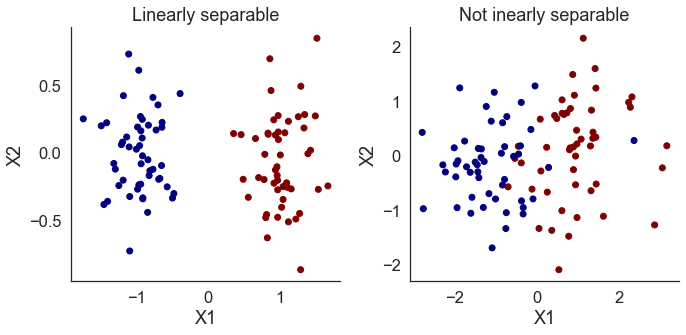

In [37]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Linearly separable')
plt.xlabel('X1')
plt.ylabel('X2')
plt.scatter(X_sep[:,0],X_sep[:,1],c=y_sep)
plt.subplot(1,2,2)
plt.title('Not inearly separable')
plt.xlabel('X1')
plt.ylabel('X2')
plt.scatter(X_nsep[:,0],X_nsep[:,1],c=y_nsep)

plt.tight_layout()

Text(0, 0.5, 'X2')

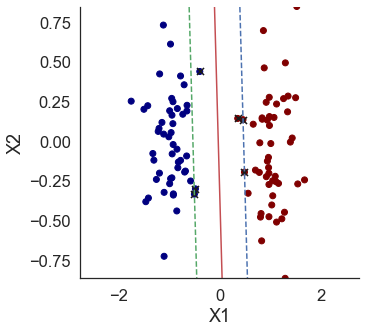

In [42]:
# make a plot funtion in utilities?
plt.figure(figsize=(5,5))
X,y = X_sep,y_sep
svc_model = svm.SVC(kernel='linear',C=1);
svc_model.fit(X, y)
plt.scatter(X[:,0],X[:,1],c=y_sep)
# Constructing a hyperplane using a formula.
w = svc_model.coef_[0]           # w consists of 2 elements
b = svc_model.intercept_[0]      # b consists of 1 element
x_points = np.linspace(-2,2)    # generating x-points from -1 to 1
y_points = -(w[0] / w[1]) * x_points - b / w[1]  # getting corresponding y-points
# Plotting a red hyperplane
plt.plot(x_points, y_points, c='r');
# Encircle support vectors
plt.scatter(svc_model.support_vectors_[:, 0],
            svc_model.support_vectors_[:, 1], 
            s=50, 
            c='k',
            marker='x');
# Step 2 (unit-vector):
w_hat = svc_model.coef_[0] / (np.sqrt(np.sum(svc_model.coef_[0] ** 2)))
# Step 3 (margin):
margin = 1 / np.sqrt(np.sum(svc_model.coef_[0] ** 2))
# Step 4 (calculate points of the margin lines):
decision_boundary_points = np.array(list(zip(x_points, y_points)))
points_of_line_above = decision_boundary_points + w_hat * margin
points_of_line_below = decision_boundary_points - w_hat * margin
# Plot margin lines
# Blue margin line above
plt.plot(points_of_line_above[:, 0], 
         points_of_line_above[:, 1], 
         'b--')
# Green margin line below
plt.plot(points_of_line_below[:, 0], 
         points_of_line_below[:, 1], 
         'g--')

plt.ylim([min(X[:,1]),max(X[:,1])])

plt.xlabel('X1')
plt.ylabel('X2')

An important feature of support vector machines with an hard margin (with slack $K=0$) is that they are only sensible to the data points $x_{i}$ that lie *on* the margin (indicated with a cross in the image above). These point are called *support vectors* and give the name to the algorithm.

### Example: decoding the stimulus identity from neural activity
---
Let's now look at how we can use SVMs to do neural decoding.  
We will use a dataset built to simulate the following scenario: a mouse is presented with a series of 100 sound stimuli, 50 of type A, and 50 of type B, randomly intermixed.
Each sound is presented for a duration of 2s, with an interval of 3s between stimuli.
While the animal is exposed to this series of sounds, we record the activity of N neurons.

Is it possible to tell, by looking at the neural activity only, which sound the animal was perceiving at each time?

To answer this question, we will divide the 2 seconds of sound presentation in 100ms-long time bins, and train a linear SVM to decode, from the neural activity in a given bin, if sound A or sound B was presented.


In [45]:
# import data
with open('data/simulated_data1.pickle', 'rb') as handle:
    data = pickle.load(handle)

spike_times = data['spike_times']
stim_onsets = data['stim_onsets']
stim_type = data['stim_type']
stim_duration = data['stim_duration']


We bin the data in 100 ms wide bin, around the presentation of each stimulus

In [11]:
onset = -1 # in seconds before stimulus onset
offset = 1 # in second after stimulus offset

binwidth = 0.1 # in seconds (100 ms)
bins = np.arange(onset,stim_duration+offset+binwidth,binwidth)


In [83]:
onset = 1 # in seconds before stimulus onset
offset = 1 # in second after stimulus offset

binwidth = 0.1 # in seconds (100 ms)
bins = np.arange(-onset,stim_duration+offset+binwidth,binwidth)

n_cells = len(spike_times)
n_trials= len(stim_type)

X = np.zeros((n_cells,n_trials,len(bins)-1));
for cell in range(n_cells):    
    for trial in range(n_trials):

        # selects spikes that are in trial
        sp_idx = np.logical_and(spike_times[cell]>stim_onsets[trial]-onset,
                 spike_times[cell]<stim_onsets[trial]+stim_duration+offset)
        
        # centers spike times around stimulus onset
        sp_cntr = spike_times[cell][sp_idx]-stim_onsets[trial]
        #bins spikes
        spike_count,_ = np.histogram(sp_cntr,bins)
        #spike_count = zscore(spike_count)
        X[cell,trial,:] = spike_count




Our dataset X has shape (n_neurons,n_stimuli,n_time bins). We can plot the activity of a given neuron over the course of the stimulus presentation, for each of the 50 presentations of stimulus A and stimulus B.

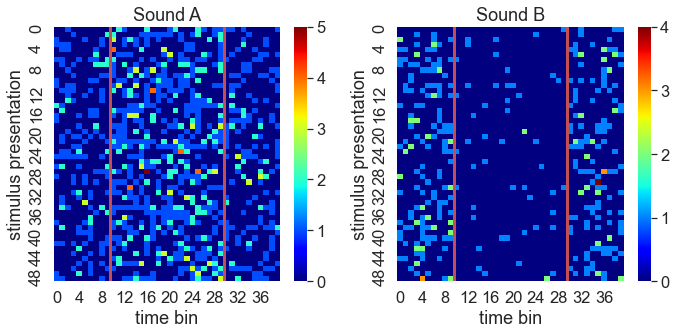

In [84]:
neuron = 3
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Sound A')
sns.heatmap(X[neuron][stim_type==1],cmap=plt.cm.jet)
plt.axvline(x=10,c='r',linewidth=3)
plt.axvline(x=30,c='r',linewidth=3)
plt.xlabel('time bin')
plt.ylabel('stimulus presentation')

plt.subplot(1,2,2)
plt.title('Sound B')
sns.heatmap(X[neuron][stim_type==2],cmap=plt.cm.jet)
plt.axvline(x=10,c='r',linewidth=3)
plt.axvline(x=30,c='r',linewidth=3)
plt.xlabel('time bin')
plt.ylabel('stimulus presentation')

plt.tight_layout()

As you can see, the activity of some neurons is clearly different between the stimuli (explore the population by changing the 'neuron' variable above). But how much information is the population carrying as a whole? Let's do some decoding to find out.

<div class="alert alert-block alert-info">

### CROSS-VALIDATION

[Cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) is a technique widely used in machine learning to make sure we are not overfitting the data. It conists in splitting our dataset in two part, the first used to estimate the parameters of our model (fitting), the second one to calculate the model performance (testing). Testing the model on different data than the ones used for fitting allows us to see how well our model generalizes, and prevents overfitting.
We can repeat the splitting procedure several times, training and testing every time on a different portion of the data. This procedure is what we call *cross-validation*

In [93]:
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.preprocessing import StandardScaler

n_splits = 5

avg_performance = []
std_performance = []

for time_bin in range(X.shape[-1]):
        # setting 2-fold cross validation
        kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
        fold_performance = []

        for train_index, test_index in kf.split(X[:,:,time_bin].T,stim_type):
                

                X_train, X_test = X[:,train_index,time_bin].T, X[:,test_index,time_bin].T
                y_train, y_test = stim_type[train_index], stim_type[test_index]

                clf = svm.LinearSVC(max_iter=1000)
                clf.fit(X_train, y_train)
                fold_performance.append(clf.score(X_test,y_test))

        avg_performance.append(np.mean(fold_performance))
        std_performance.append(np.std(fold_performance))

avg_performance = np.asarray(avg_performance)
std_performance = np.asarray(std_performance)




We have now an average model performance, and the corresponding standard deviation, for each of the time bins. We can plot the timecourse.

Text(0, 0.5, 'Decoding performance')

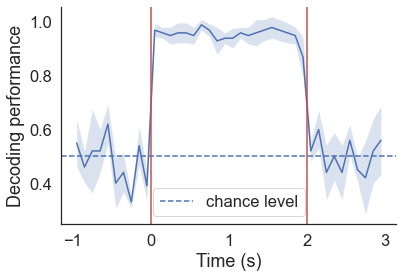

In [94]:
bin_centers = [(bins[i+1]+bins[i])/2 for i in range(len(bins)-1)]
plt.plot(bin_centers,avg_performance)
plt.fill_between(bin_centers,avg_performance-std_performance,
                 avg_performance+std_performance,alpha=0.2)

plt.axhline(y=0.5,linestyle='--',label='chance level')
plt.axvline(x=0,c='r')
plt.axvline(x=2,c='r')

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Decoding performance')


## Assessing significance with surrogate data
---
How can we distiguish actual information from random fluctiation?  
To asses if the performance of our classifier is significantly different from what would be expected by chance, we need a statistical *null model* to compare to.  

A powerfull way to construct null models is to use a shuffling procedure to destroy the structure in the data (in our case the relationship between features and labels), and see what results would our classifier give in that case: this is the performance expected by chance.  
If we repeat this procedure multiple times, we can get a 'surrogate' distribution, informing us on how the preformance of random classifiers would ditribute. This method, closely related to (permutation tests)[https://en.wikipedia.org/wiki/Permutation_test], is a very versatile tool to discriminate signal from noise in many real-world situation, in which often the underlying distribution of the data is uknown or too complex to estimate significance analytically.

Surrogate distribution are not a silver bullet, however. The kind of shuffling we perform can disrupt or preserve different features of the structure of our data, and always comes with underlying hypothesis to be mindful of.

Let's see what shuffling can tell us about our stimulus decoder.



### Example: computing significance on decoding performance
---

In [95]:
from tqdm import tqdm 

n_shuffles = 100 # number of surrogates for each bin
performance = []
surrogate_performance = []
for time_bin in range(X.shape[-1]):
        # setting 2-fold cross validation
        kf = StratifiedKFold(n_splits=2)
        fold_performance = []
        surrogate_fold_performance = []

        for train_index, test_index in kf.split(X[:,:,time_bin].T,stim_type):
            print(f'Computing time bin {time_bin}/{X.shape[-1]}')

            X_train, X_test = X[:,train_index,time_bin].T, X[:,test_index,time_bin].T
            y_train, y_test = stim_type[train_index], stim_type[test_index]

            clf = svm.LinearSVC(loss='hinge')
            clf.fit(X_train, y_train)
            fold_performance.append(clf.score(X_test,y_test))


            for s in tqdm(range(n_shuffles)):
                stim_type_shuff = np.random.permutation(stim_type)
                y_train_shuff, y_test_shuff = stim_type_shuff[train_index], stim_type_shuff[test_index]
                clf = svm.LinearSVC(loss='hinge')
                clf.fit(X_train, y_train_shuff)
                surrogate_fold_performance.append(clf.score(X_test,y_test_shuff))


        performance.append(np.mean(fold_performance))
        surrogate_performance.append(surrogate_fold_performance)

performance = np.asarray(performance)
surrogate_performance = np.asarray(surrogate_performance)


  0%|          | 0/100 [00:00<?, ?it/s]

Computing time bin 0/40
Computing time bin 0/40
Computing time bin 1/40


  0%|          | 0/100 [00:00<?, ?it/s]

Computing time bin 1/40
Computing time bin 2/40
Computing time bin 2/40
Computing time bin 3/40


  0%|          | 0/100 [00:00<?, ?it/s]

Computing time bin 3/40
Computing time bin 4/40
Computing time bin 4/40
Computing time bin 5/40


  0%|          | 0/100 [00:00<?, ?it/s]

Computing time bin 5/40
Computing time bin 6/40
Computing time bin 6/40
Computing time bin 7/40


  0%|          | 0/100 [00:00<?, ?it/s]

Computing time bin 7/40
Computing time bin 8/40
Computing time bin 8/40
Computing time bin 9/40


  0%|          | 0/100 [00:00<?, ?it/s]

Computing time bin 9/40
Computing time bin 10/40
Computing time bin 10/40
Computing time bin 11/40


100%|██████████| 100/100 [00:00<00:00, 1491.94it/s]

Computing time bin 11/40
Computing time bin 12/40
Computing time bin 12/40



  0%|          | 0/100 [00:00<?, ?it/s]

Computing time bin 13/40
Computing time bin 13/40
Computing time bin 14/40
Computing time bin 14/40


100%|██████████| 100/100 [00:00<00:00, 1416.11it/s]


Computing time bin 15/40
Computing time bin 15/40
Computing time bin 16/40
Computing time bin 16/40


  0%|          | 0/100 [00:00<?, ?it/s]

Computing time bin 17/40
Computing time bin 17/40
Computing time bin 18/40


  0%|          | 0/100 [00:00<?, ?it/s]

Computing time bin 18/40
Computing time bin 19/40
Computing time bin 19/40
Computing time bin 20/40


  0%|          | 0/100 [00:00<?, ?it/s]

Computing time bin 20/40
Computing time bin 21/40
Computing time bin 21/40
Computing time bin 22/40


  0%|          | 0/100 [00:00<?, ?it/s]

Computing time bin 22/40
Computing time bin 23/40
Computing time bin 23/40
Computing time bin 24/40


  0%|          | 0/100 [00:00<?, ?it/s]

Computing time bin 24/40
Computing time bin 25/40
Computing time bin 25/40
Computing time bin 26/40


  0%|          | 0/100 [00:00<?, ?it/s]

Computing time bin 26/40
Computing time bin 27/40
Computing time bin 27/40
Computing time bin 28/40


  0%|          | 0/100 [00:00<?, ?it/s]

Computing time bin 28/40
Computing time bin 29/40
Computing time bin 29/40


  0%|          | 0/100 [00:00<?, ?it/s]

Computing time bin 30/40
Computing time bin 30/40
Computing time bin 31/40
Computing time bin 31/40


  0%|          | 0/100 [00:00<?, ?it/s]

Computing time bin 32/40
Computing time bin 32/40
Computing time bin 33/40
Computing time bin 33/40


  0%|          | 0/100 [00:00<?, ?it/s]

Computing time bin 34/40
Computing time bin 34/40
Computing time bin 35/40
Computing time bin 35/40


  0%|          | 0/100 [00:00<?, ?it/s]

Computing time bin 36/40
Computing time bin 36/40
Computing time bin 37/40
Computing time bin 37/40


  0%|          | 0/100 [00:00<?, ?it/s]

Computing time bin 38/40
Computing time bin 38/40
Computing time bin 39/40
Computing time bin 39/40


100%|██████████| 100/100 [00:00<00:00, 1710.96it/s]


We have computed a surrogate distribution for each bin, let's now look at how this distribtions look like, and how the classifier performance compares to them.  
Here are two examples, for time bin 0 (outside the stimulus presentation period) and for bin 20 (inside the presentation period)

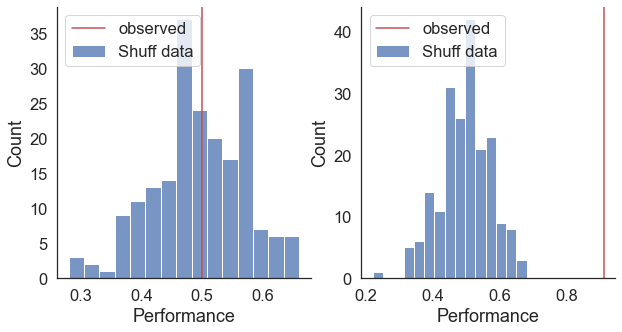

In [101]:
plt.figure(figsize=(10,5))

# Plot for bin 0
plt.subplot(1,2,1)
sns.histplot(surrogate_performance[0],bins=15,label='Shuff data')
plt.axvline(x=performance[0],c='r',label='observed')
plt.xlabel('Performance')
sns.despine()
plt.legend()

# Plot for bin 20 
plt.subplot(1,2,2)
sns.histplot(surrogate_performance[20],bins=15,label='Shuff data')
plt.axvline(x=performance[20],c='r',label='observed')
plt.xlabel('Performance')
sns.despine()
plt.legend()


As you can see, when no information about the stimulus is present, the oberved performance falls well within the shuffled distribution. When the stimulus is present instead, the classification performance is clearly larger than expected by chance.

You can quantify this effect by calculating an *effect size* and a *p value*. Notice that, since we have access to the full distribution our null hypothesis, we can chose the most appropriate statistical test.

We can in fact visualize the full timecourse of the stimulus by plotting, together with the experimental performance, a measure of location (e.g. mean or median) and dispersion (e.g. standard deviation or inter-quartile range) of the surrogate distribution, as shown below:

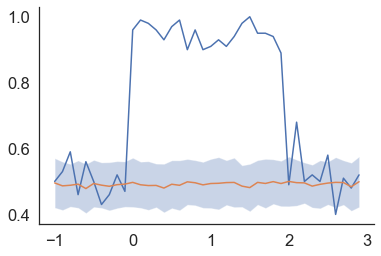

In [102]:
mean_shuff = np.mean(surrogate_performance,axis=-1)
std_shuff = np.std(surrogate_performance,axis=-1)
plt.plot(bins[:-1],performance)
plt.fill_between(bins[:-1],mean_shuff-std_shuff,mean_shuff+std_shuff,alpha=0.3)
plt.plot(bins[:-1],mean_shuff)

<div class="alert alert-block alert-info">

### Key points 

- Linear SVMs fit the largest possible margin between the data classes, with penalization for point that fall on the wrong side of the margin.
- SVMs can be used to decode stimulus identity by training a classifier to predict the identity of the presented stimulus from the neural activity at the corresponding time.
- We can build a statistical null model by shuffling our data and destroying the relationship between features and labels. This procedure can help us asses the effect size and the statistical significance of our classification. 


<div class="alert alert-block alert-info">

### References and resources

**Books & papers**

**Websites & blogposts**

**Software**




## Exercises
You can find the exercises for this lessons in [exercises.ipynb](./exercises.ipynb)